Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import torch
from PIL import Image
import PIL.ImageOps
import numpy as np

from pykalman import KalmanFilter
import scipy
import scipy.optimize

import matplotlib.pyplot as plt

import cv2

import train
import kf_particle

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
net = train.UNet()
net.load_state_dict(torch.load('data/weights/net03'))

net.train(False)
device = torch.device('cuda')
net = net.to(device=device)

In [4]:
def find_balls(pred):
    balls = []

    while True:
        a = torch.nn.functional.conv2d(pred.unsqueeze(0).unsqueeze(0), torch.ones(1, 1, 20, 20).to(device=device)).squeeze(0).squeeze(0)
        if torch.max(a) < 0.6 * 20 * 20:
            break
        max_index = torch.argmax(a)
        max_x = max_index % a.shape[1] + 10
        max_y = max_index // a.shape[1] + 10
        pred[max_y-20:max_y+20, max_x-20:max_x+20] = 0
        balls.append(np.array([max_x.item(), max_y.item()]))

    return balls

In [5]:
ballss = []
for i in range(467):
    if i % 50 == 0:
        print(i)
    with torch.no_grad():
        img = Image.open('data/cap3/img/%03d.png' % i)
        img = torch.from_numpy(np.array(img).transpose((2, 0, 1))).type(torch.FloatTensor).to(device=device)
        pred = net(img.unsqueeze(0)).squeeze(0).squeeze(0)
        pred = sigmoid(pred)
    ballss.append(find_balls(pred))

# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 256)
# plt.subplot(1, 2, 2)
# plt.imshow(pred.cpu().numpy(), vmax=1, vmin=0)

0
50
100
150
200
250
300
350
400
450


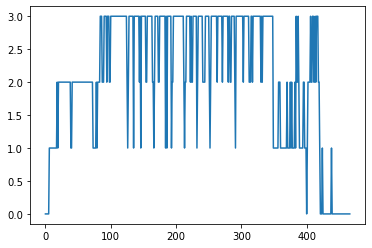

In [21]:
_ = plt.plot([len(balls) for balls in ballss])

In [7]:
ancestor_lag = 5

hp = kf_particle.Hyperparameters(lambda_drop=0.1, lambda_spur=0.1, max_particles=200)
particles = [
    kf_particle.Particle(
        means=np.zeros((0, 6)),
        covariances=np.zeros((0, 6, 6)),
        ancestors=np.full(ancestor_lag, -1, dtype=int),
        ancestor_buffer_cur=0
    )
] * hp.max_particles

e_ball_count = []
confirmed_ancestors = []
particle_history = [None] * ancestor_lag
particle_history_idx = 0
good_particles = []
for (i, obs) in enumerate(ballss):
    particle_history[particle_history_idx] = particles
    particle_history_idx += 1
    particle_history_idx %= len(particle_history)
    
    if i % 50 == 0:
        print(i)
    obs = np.array(obs)
    if obs.shape[0] == 0:
        obs = obs.reshape((0, 2))
    particles, confirmed_ancestor = kf_particle.particle_filter_update(particles, 0.03, obs, hp, i * hp.max_particles)
    confirmed_ancestors.append(confirmed_ancestor)
    
    if confirmed_ancestor is not None and confirmed_ancestor != -1:
        ancestor_particles = particle_history[(particle_history_idx + 1) % len(particle_history)]
        good_particle = [p for p in ancestor_particles if p.id() == confirmed_ancestor][0]
        good_particles.append(good_particle)
    
    total_balls = 0.0
    for p in particles:
        total_balls += p.means.shape[0]
    e_ball_count.append(total_balls / float(len(particles)))

0
50
100
150
200
250
300
350
400
450


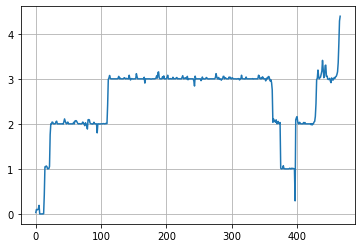

In [22]:
plt.grid(True)
_ = plt.plot(e_ball_count)

In [14]:
means = [p.means for p in good_particles]
first_means = np.array([p[0, :] for p in means if p.shape[0] >= 1])
second_means = np.array([p[1, :] for p in means if p.shape[0] >= 2])
third_means = np.array([p[2, :] for p in means if p.shape[0] >= 3])

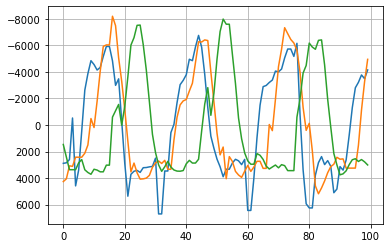

In [23]:
a, b = 100, 200
plt.gca().invert_yaxis()
plt.grid(True)
col = 5
plt.plot(first_means[a:b, col])
plt.plot(second_means[a:b, col])
_ = plt.plot(third_means[a:b, col])

In [16]:
def plot_result(i):
    img = Image.open('data/cap3/img/%03d.png' % i)
    
    means = good_particles[i].means
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.quiver(means[:, 0], means[:, 3], means[:, 2], -means[:, 5], color='yellow', scale=3e4)
    plt.scatter(means[:, 0], means[:, 3], c=(['r', 'g', 'b'] + ['white'] * 10)[0:means.shape[0]])
    balls = ballss[i]
    plt.scatter([b[0] for b in balls], [b[1] for b in balls], s=80, facecolors='none', edgecolors='orange', linewidth=3)
    plt.savefig('data/animation/%03d.png' % i)
    plt.close()

In [18]:
for i in range(len(good_particles)):
    if i % 10 == 0:
        print(i)
    plot_result(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
